# W281 - Computer Vision

### Final Project - Fashion Items Classification

*by Shazia Nooruddin, Edgar Leon and Abhinav Sharma*


**Link to dataset:**

https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data


| Items         | Count |
| ------------- | ----- |
| Casual Shoes  | 1322  |
| Watches       | 1249  |
| Pants         | 1139  |
| T-Shirts      | 1116  |

**Problem Statement:**

An e-commerce company is selling fashion items and they've received complaints that the image of the product doesn't match the product description. They need help reorganizing their image data so that they can represent their products accurately. Our job is to build a classifier that can label thousands of
fashion images quickly so that the company can match the image to their product faster.


## Imports


In [2]:
# Load packages
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import colorsys
from numpy import expand_dims
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time
from sklearn.model_selection import GridSearchCV


# import tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# import other features
from skimage.feature import (corner_subpix, corner_peaks, corner_harris, hog,
                             corner_orientations, local_binary_pattern)

# imports for vbow
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans


## Utility Functions

In [3]:
# prints 1 image, as is
def print_img(img):
  plt.figure(figsize=(2, 2))
  plt.imshow(img)
  plt.axis('off')

# converts from bgr to rgb
def to_rgb_img(img, return_img=False, display_img=True):
  rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  if display_img:
    print_img(rgb_img)

  if return_img:
    return rgb_img

# displays feature image side by side with original image (with label)
def display_featimg_against_original(feat_img, original_img, label):
  fig, axarr = plt.subplots(1, 2, figsize=(2, 2))
  plt.axis('off')
  axarr[0].set_xticks([])
  axarr[0].set_yticks([])

  axarr[0].imshow(feat_img)
  axarr[1].imshow(original_img)
  fig.suptitle(label, fontsize=12)

def display_featimg_against_original_wrapper(feat_imgs, data_orig):
  # feature images and data images must be idx aligned for labels to match
  for i, feat_img in enumerate(feat_imgs):
    article_type = data_orig[['articleType']]
    label = article_type.iloc[i]['articleType']

    imgs = data_orig[['image']]
    original_img = imgs.iloc[i]['image']

    display_featimg_against_original(feat_img, original_img, label=label)

# most images in the dataset are 80 x 60
def resize_image(img, width=80, height=60):
    return cv.resize(img, (height, width), interpolation=cv.INTER_LINEAR)

# get a random image
def get_random_img(data, with_label=True):
  imgs = data[['image', 'articleType']]
  imgs = imgs.reset_index(drop=True)

  img_len = len(imgs)
  img_idx = random.randint(0, img_len)

  if with_label:
    return imgs.iloc[img_idx]['image'], imgs.iloc[img_idx]['articleType']

  return imgs.iloc[img_idx]['image']

# gets an image dictionary for each class
def get_one_img_each_class(df):
  pants_idx = random.choice(df.index[df['articleType'] == 'Pants'].tolist())
  tshirts_idx = random.choice(df.index[df['articleType'] == 'Tshirts'].tolist())
  watches_idx = random.choice(df.index[df['articleType'] == 'Watches'].tolist())
  shoes_idx = random.choice(df.index[df['articleType'] == 'Casual Shoes'].tolist())

  result = dict()
  result['Pants'] = df.iloc[pants_idx]['image']
  result['Tshirts'] = df.iloc[tshirts_idx]['image']
  result['Watches'] = df.iloc[watches_idx]['image']
  result['Casual Shoes'] = df.iloc[shoes_idx]['image']
  return result

# get all images by class in dict format
def get_all_img_by_class(df):
  df = df.reset_index(drop=True)
  pants = df.index[df['articleType'] == 'Pants'].tolist()
  tshirts = df.index[df['articleType'] == 'Tshirts'].tolist()
  watches = df.index[df['articleType'] == 'Watches'].tolist()
  shoes = df.index[df['articleType'] == 'Casual Shoes'].tolist()

  from collections import defaultdict
  result = defaultdict(list)
  for p in pants:
    result['Pants'].append(df.iloc[p]['image'])

  for t in tshirts:
    result['Tshirts'].append(df.iloc[t]['image'])

  for w in watches:
    result['Watches'].append(df.iloc[w]['image'])

  for s in shoes:
    result['Casual Shoes'].append(df.iloc[s]['image'])

  return result

def count_categories_summary(df):
  total = len(df)
  total_pants = len(df[df["articleType"]=="Pants"])
  total_tshirts = len(df[df["articleType"]=="Tshirts"])
  total_watches = len(df[df["articleType"]=="Watches"])
  total_shoes = len(df[df["articleType"]=="Casual Shoes"])
  assert total == total_pants + total_tshirts + total_watches + total_shoes

  print(f"Total rows: {total}, out of which pants: {total_pants}, tshirts: {total_tshirts}, watches: {total_watches}, shoes: {total_shoes}")
  print(f"Pants %: {total_pants / (0.01 * total)}, tshirts %: {total_tshirts / (0.01 * total)}, watches %: {total_watches / (0.01 * total)}, shoes: {total_shoes / (0.01 * total)}")

## Load Dataset

In [4]:
from google.colab import drive
# https://github.com/W281/W281-FashionClassification/blob/main/data.pkl
# Instructions -
'''
1. Download above file into your laptop
2. Upload data.pkl only once in MyDrive/W281/data.pkl
'''
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read in data
df = pd.read_pickle('/content/drive/MyDrive/W281/data.pkl')

In [6]:
# Looks like there is a null value in here for 1 image
if df[df['image'].isnull()].any()['id']:
  # Drop the null image
  df = df.drop(1961).reset_index(drop=True)

print(df.shape)

(4825, 3)


In [7]:
# Shuffle data
df = df.sample(frac=1)

In [8]:
# Display all columns
df.columns

Index(['id', 'articleType', 'image'], dtype='object')

In [9]:
# Display all classes
df['articleType'].unique()

array(['Watches', 'Casual Shoes', 'Tshirts', 'Pants'], dtype=object)

In [10]:
# Convert data to uint8, resize and convert to rgb
for i in range(len(df)):
  df['image'][i] = df['image'][i].astype(np.uint8)
  df['image'][i] = resize_image(df['image'][i])
  df['image'][i] = to_rgb_img(df['image'][i], return_img=True, display_img=False)

for i in range(len(df)):
  assert df['image'][i].shape == (80, 60, 3)

# drop ID column, not needed
df = df.reset_index(drop=True)

<ipython-input-10-16dd30a9799a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][i] = df['image'][i].astype(np.uint8)
<ipython-input-10-16dd30a9799a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][i] = resize_image(df['image'][i])
<ipython-input-10-16dd30a9799a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][i] = to_rgb_img(df['image'][i], return_img=True, display_img=False)


In [11]:
count_categories_summary(df)

Total rows: 4825, out of which pants: 1138, tshirts: 1116, watches: 1249, shoes: 1322
Pants %: 23.585492227979273, tshirts %: 23.129533678756477, watches %: 25.8860103626943, shoes: 27.39896373056995


In [12]:
from sklearn.model_selection import train_test_split

# TODO: partition examples by category in train, test and val sets
# We want to ensure 70% of shoes land in train, 20% in test, 10% in val

# Specify the proportion for train, test, and validation sets
train_size = 0.7  # 70% for training
test_size = 0.2   # 20% for testing
validation_size = 0.1  # 10% for validation

# Perform the train-test-validation split
train_data, temp_data = train_test_split(df, test_size = 1 - train_size, random_state=42)
test_data, validation_data = train_test_split(temp_data,
                                              test_size=validation_size/(validation_size + test_size),
                                              random_state=42)

# Display the shapes of the resulting DataFrames
print("Train set shape: ", train_data.shape)
print("Test set shape: ", test_data.shape)
print("Validation set shape: ", validation_data.shape)

Train set shape:  (3377, 3)
Test set shape:  (965, 3)
Validation set shape:  (483, 3)


## Data Preprocessing & Feature Engineering

For preprocessing the data, we will look to do a few things:
1. HSV conversion
2. Contrast normalization
3. Auto gamma correction
4. Color vs grayscale

For feature engineering, we will look to explore a few features:
1. HOG
2. NN Based Feature
3. SIFT / Harris / BRISK Corner
4. Local Binary Pattern
5. RGB or HSV color histograms
6. Canny Filters

### Get Sample Images for Each Class

For feature testing


In [13]:
# read only, please do not modify!
sample_img, sample_label = get_random_img(train_data)
sample_img.shape

(80, 60, 3)

In [14]:
# read only, please do not modify!
sample_imgs_dict = get_one_img_each_class(df)
sample_imgs_list = []
for k,v in sample_imgs_dict.items():
  sample_imgs_list.append([k,v])

# read only, please do not modify!
sample_df = pd.DataFrame(sample_imgs_list, columns=['articleType', 'image'])
sample_df

,articleType,image
0,Pants,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Tshirts,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Watches,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Casual Shoes,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [15]:
train_data_dict = get_all_img_by_class(train_data)
test_data_dict = get_all_img_by_class(test_data)

In [16]:
len(train_data_dict['Pants'])

793

In [17]:
len(test_data_dict['Pants'])

234

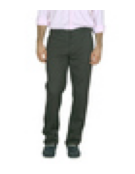

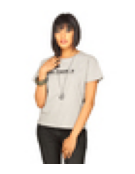

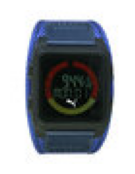

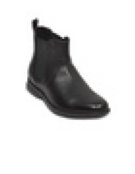

In [18]:
# Check if data looks ok
print_img(sample_imgs_dict['Pants'])
print_img(sample_imgs_dict['Tshirts'])
print_img(sample_imgs_dict['Watches'])
print_img(sample_imgs_dict['Casual Shoes'])

### Preprocessing

#### HSV Conversion

HSV is a good color space for visualization when there is dense directional information over an image. The HSV model expresses the intensity of the image (V) independently of the color (H, S).
Here are some details about HSV:

1. Hue: Specifies the angle of the color on the RGB color circle. Hue is measured in degrees from 0 to 360. For example, cyan falls between 181–240 degrees, and magenta falls between 301–360 degrees.

2. Saturation: The dominant description for black and white is the term, value. The hue and saturation level do not make a difference when the value is at max or min intensity level.

3. Value: Expresses the intensity of the image.

In [19]:
# converts from rgb to hsv
def to_hsv_img(img, return_img=False, display_img=True):
  (x, y, c) = img.shape
  hsv_img = img.copy()

  # TODO: this is inefficient, make it better
  for i in range(x):
    for j in range(y):
      (h, s, v) = colorsys.rgb_to_hsv(img[i, j, 0], img[i, j, 1], img[i, j, 2])
      hsv_img[i, j, 0] = h
      hsv_img[i, j, 1] = s
      hsv_img[i, j, 2] = v

  if display_img:
    print_img(hsv_img)

  if return_img:
    return hsv_img

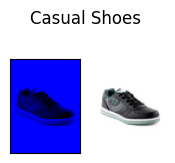

In [20]:
hsv_img = to_hsv_img(sample_img, return_img=True, display_img=False)
display_featimg_against_original(hsv_img, sample_img, sample_label)

### HOG Feature

Histogram of Oriented Gradients, also known as HOG, is a feature descriptor like the Canny Edge Detector, SIFT (Scale Invariant and Feature Transform) . It is used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in the localized portion of an image. This method is quite similar to Edge Orientation Histograms and Scale Invariant aFeature Transformation (SIFT). The HOG descriptor focuses on the structure or the shape of an object. It is better than any edge descriptor as it uses magnitude as well as angle of the gradient to compute the features. For the regions of the image it generates histograms using the magnitude and orientations of the gradient.

In [21]:
def hog_feature(images, gauss_kernel=5, orientations=8, px_per_cell=8, cells_per_block=2, block_norm='L2'):
  hog_images = []
  hog_features = []
  train_images = list(images)

  for image in tqdm(train_images):
    blur = cv.GaussianBlur(image,(gauss_kernel, gauss_kernel), 0)
    fd, hog_image = hog(blur, \
                       orientations = orientations, \
                       pixels_per_cell = (px_per_cell, px_per_cell), \
                       cells_per_block = (cells_per_block, cells_per_block), \
                       block_norm = block_norm, \
                       visualize = True, \
                       channel_axis = -1)

    hog_images.append(hog_image)
    hog_features.append(fd)

  hog_features = np.array(hog_features)
  print(f"\nHog features shape is {hog_features.shape}")

  return hog_features, hog_images

100%|██████████| 4/4 [00:00<00:00, 58.44it/s]



Hog features shape is (4, 1728)


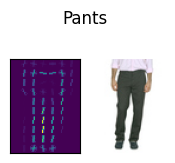

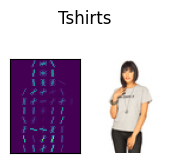

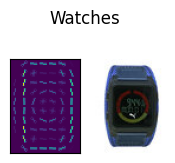

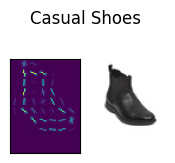

In [22]:
hog_features_sample, hog_images_sample = hog_feature(sample_df['image'])
assert len(hog_images_sample) == len(sample_df)
display_featimg_against_original_wrapper(hog_images_sample, sample_df)

In [23]:
# do it for the entire train set
hog_features_train, hog_images_train = hog_feature(train_data['image'])
assert len(hog_images_train) == len(train_data)

100%|██████████| 3377/3377 [00:26<00:00, 129.67it/s]


Hog features shape is (3377, 1728)


In [24]:
# do it for the entire validation set
hog_features_val, hog_images_val = hog_feature(validation_data['image'])
assert len(hog_images_val) == len(validation_data)

100%|██████████| 483/483 [00:04<00:00, 106.41it/s]


Hog features shape is (483, 1728)


In [25]:
# do it for the entire test set
hog_features_test, hog_images_test = hog_feature(test_data['image'])
assert len(hog_images_test) == len(test_data)

100%|██████████| 965/965 [00:06<00:00, 159.83it/s]


Hog features shape is (965, 1728)


### Neural Network Based Features

Uses embeddings from pre-trained NN to create feature vectors for the images. The weights of the NN are based on image-net dataset.

#### VGG Feature

Can try other variants simply substituting the model param: https://keras.io/api/applications/vgg/

In [26]:
def nn_feature_description(model=None):
  if not model:
    model = VGG16()

  print(model.summary())

  idx_conv_layer = -1
  conv_layer_idxs = []
  for layer in model.layers:
    idx_conv_layer +=1
    # check for convolutional layer only
    if 'conv' not in layer.name:
        continue

    conv_layer_idxs.append(idx_conv_layer)
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

    # normalize filter values
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # plot first few filters
    n_filters, ix = 2, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]

        # plot each channel separately
        for j in range(3):
        # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1

        plt.title(f"For filter {i} in layer {len(conv_layer_idxs)}")

    # show the figure
    plt.show()
    print("\n")

  return conv_layer_idxs

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

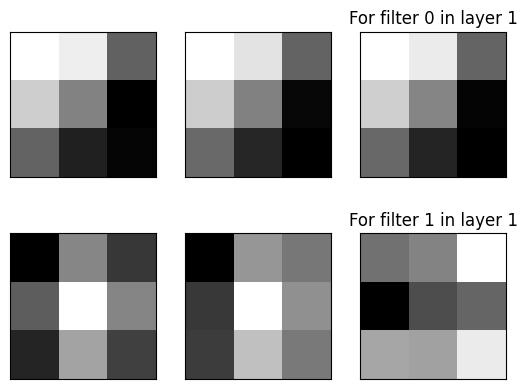



block1_conv2 (3, 3, 64, 64)


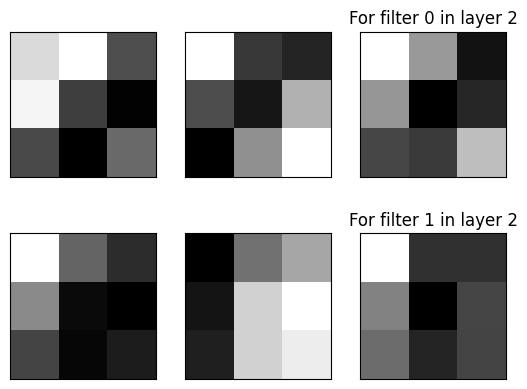



block2_conv1 (3, 3, 64, 128)


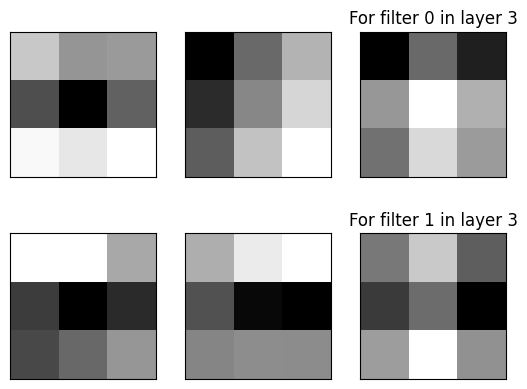



block2_conv2 (3, 3, 128, 128)


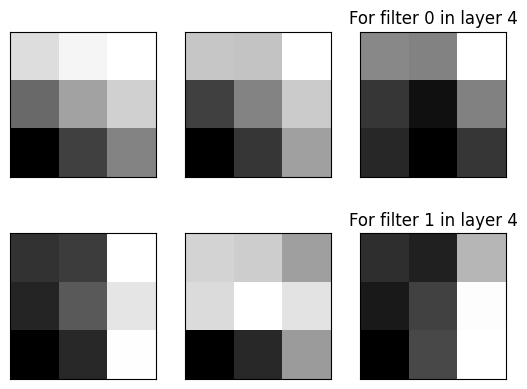



block3_conv1 (3, 3, 128, 256)


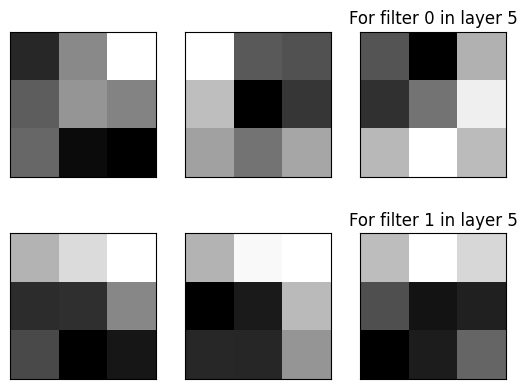



block3_conv2 (3, 3, 256, 256)


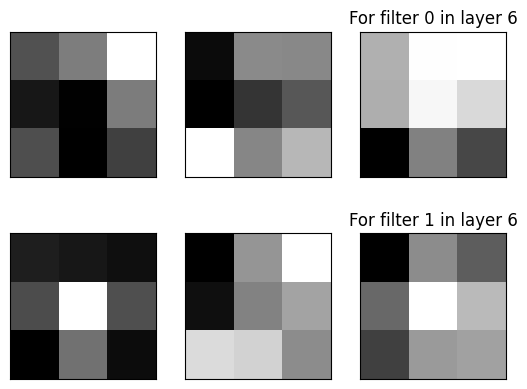



block3_conv3 (3, 3, 256, 256)


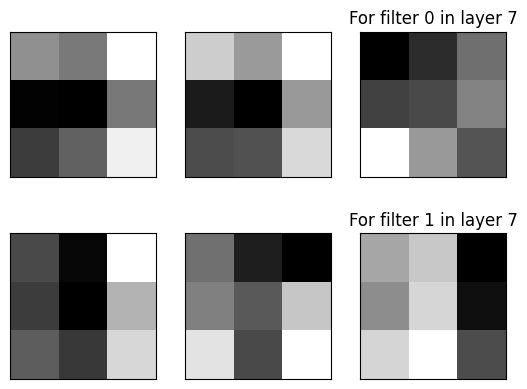



block4_conv1 (3, 3, 256, 512)


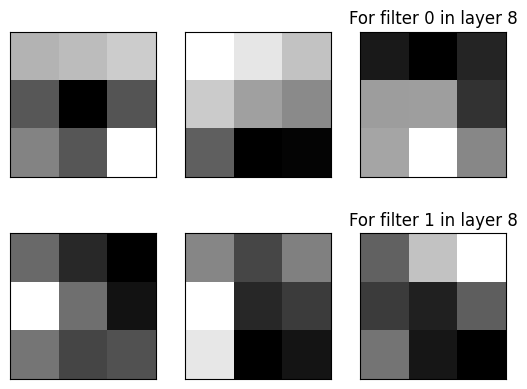



block4_conv2 (3, 3, 512, 512)


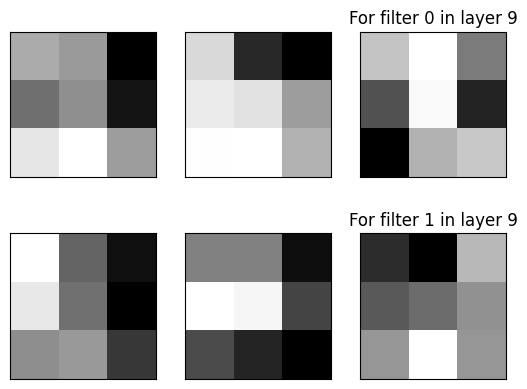



block4_conv3 (3, 3, 512, 512)


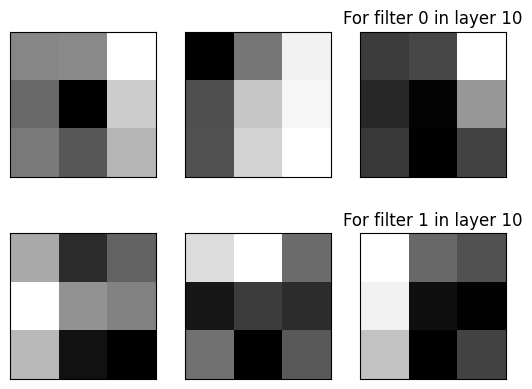



block5_conv1 (3, 3, 512, 512)


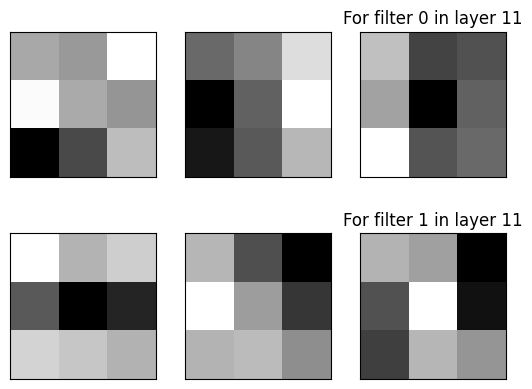



block5_conv2 (3, 3, 512, 512)


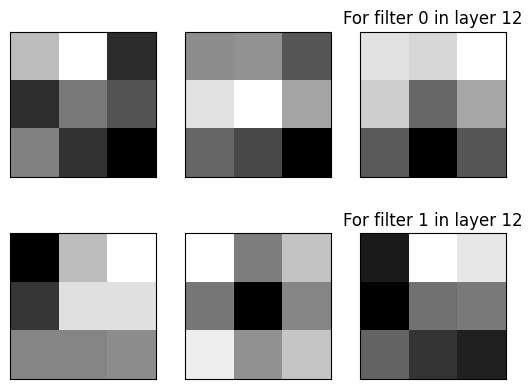



block5_conv3 (3, 3, 512, 512)


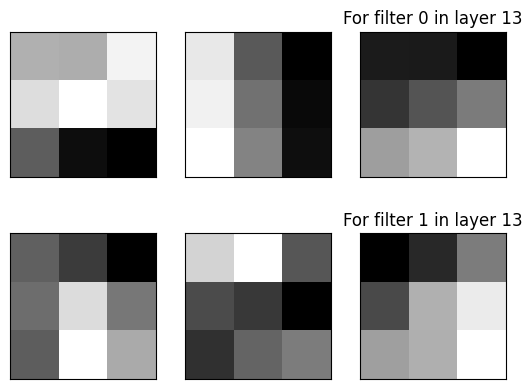

In [27]:
conv_layer_idxs = nn_feature_description()

In [28]:
# for a single layer, print feature map for all classes
def nn_feature_map_from_sample_layer(data, conv_layer_idx, model=None):
  if not model:
    model = VGG16()
  # create custom model
  # pick any conv layer as output -- located at index "idx" from vgg model
  # (look at model.summary to see that conv layer is idx 1 for example)
  model_custom = Model(inputs=model.inputs, outputs=model.layers[conv_layer_idx].output)
  plt.figure(figsize=(5,5))
  for i in range(len(data)):
    image = data.iloc[i]['image']
    label = data.iloc[i]['articleType']
    # change target size of image to fit vgg input layer size
    # (80 x 60 won't work as matmul breaks)
    # Error: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 224, 224, 3)
    image = resize_image(image, 224, 224)
    image = expand_dims(image, axis=0)
    image = preprocess_input(image)
    print(f"\nImage size is {image.shape} and label is {label}")

    feature_maps = model_custom.predict(image)
    square = 8
    ix = 1
    for _ in range(square):
        for _ in range(square):

            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1

    # show the figure
    plt.show()


Image size is (1, 224, 224, 3) and label is Pants
1/1 [==============================] - 0s 183ms/step


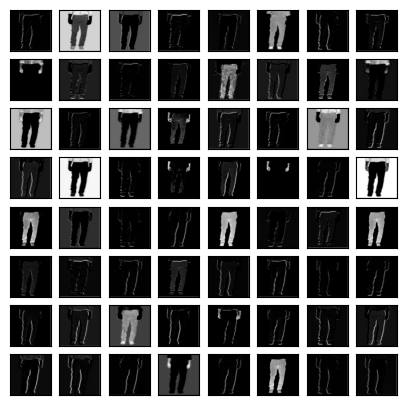


Image size is (1, 224, 224, 3) and label is Tshirts
1/1 [==============================] - 0s 23ms/step


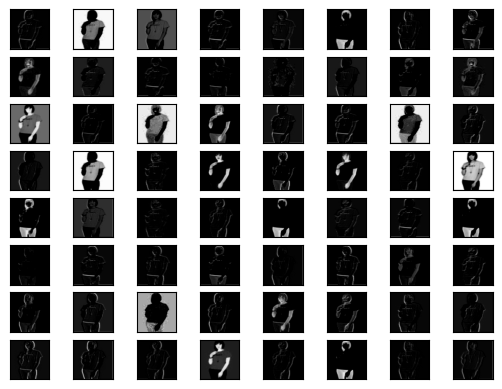


Image size is (1, 224, 224, 3) and label is Watches
1/1 [==============================] - 0s 28ms/step


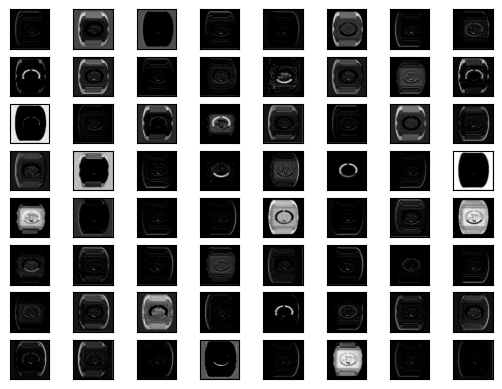


Image size is (1, 224, 224, 3) and label is Casual Shoes
1/1 [==============================] - 0s 28ms/step


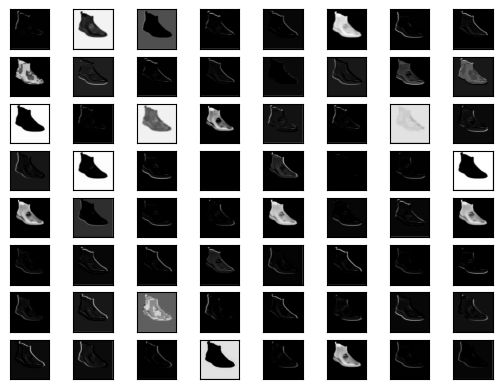

In [29]:
# display feature map for a given convolution layer as output for all classes
# play around with different conv layers in the vgg model

# earlier layers, ie, at conv_layer_idxs[0] seems to focus on shape info in filters
nn_feature_map_from_sample_layer(sample_df, conv_layer_idx=conv_layer_idxs[0])


Image size is (1, 224, 224, 3) and label is Pants
1/1 [==============================] - 0s 115ms/step


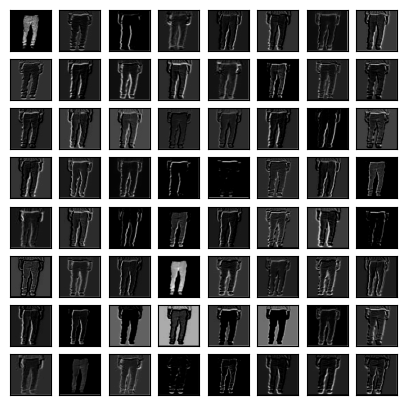


Image size is (1, 224, 224, 3) and label is Tshirts
1/1 [==============================] - 0s 88ms/step


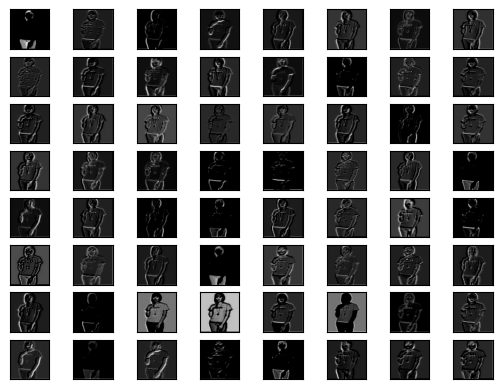


Image size is (1, 224, 224, 3) and label is Watches
1/1 [==============================] - 0s 84ms/step


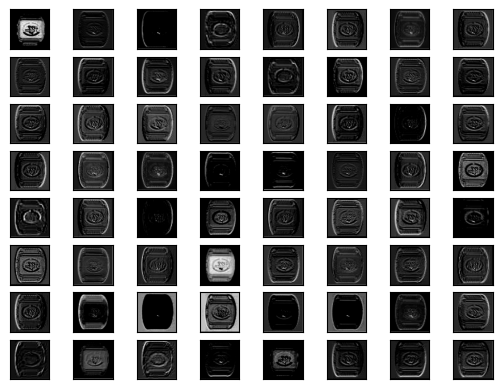


Image size is (1, 224, 224, 3) and label is Casual Shoes
1/1 [==============================] - 0s 123ms/step


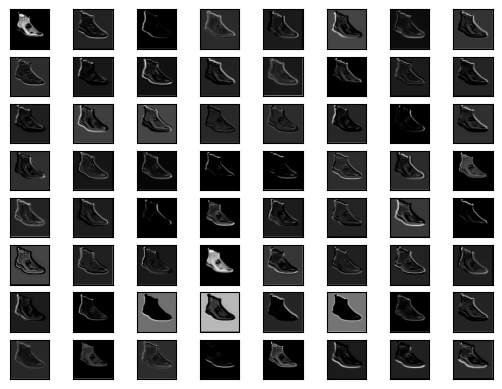

In [30]:
# later layers, ie, at conv_layer_idxs_vgg[2] seems to focus on texture info
nn_feature_map_from_sample_layer(sample_df, conv_layer_idx=conv_layer_idxs[2])

In [31]:
def nn_feature(images, model=None):
  if not model:
    model = VGG16()

  features = []
  errors = []
  for idx, image in enumerate(images):
    try:
        image = resize_image(image, 224, 224)
        image = expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature_maps = model.predict(image)
        features.append(feature_maps)
    except Exception as err:
        print(f"Exception occurred at idx {idx}")
        errors.append([idx, err])
        # VGG outputs 1 x 1000 array
        # TODO: fill this with average arr values of that class which errored out
        features.append(np.zeros((1, 1000)))
        continue

  # convert from python list to np array
  n = len(features)
  features = np.array(features).reshape((n, 1000))

  return features, errors

In [32]:
vgg_features_sample, vgg_error_idx_sample = nn_feature(sample_df['image'])
assert len(vgg_features_sample) == len(sample_df)

1/1 [==============================] - 0s 387ms/step


In [33]:
print(vgg_features_sample.shape)
print(type(vgg_features_sample[0]))

(4, 1000)
<class 'numpy.ndarray'>


In [34]:
# do it for the entire train set (this takes time, uncomment when needed)
vgg_features_train, vgg_error_idx_train = nn_feature(train_data['image'][:50])
assert len(vgg_features_train) == len(train_data[:50])

1/1 [==============================] - 0s 386ms/step


#### Resnet 101 Feature

Can try other variants simply substituting the model param: https://keras.io/api/applications/resnet/

In [35]:
resnet101_features_sample, resnet101_error_idx_sample = nn_feature(sample_df['image'], model=ResNet101())
assert len(resnet101_features_sample) == len(sample_df)

1/1 [==============================] - 0s 241ms/step


In [36]:
print(resnet101_features_sample.shape)

(4, 1000)


In [37]:
# run resnet on examples from train set
resnet101_features_train, resnet101_error_idx_train = nn_feature(train_data['image'], model=ResNet101())
assert len(resnet101_features_train) == len(train_data)

1/1 [==============================] - 0s 308ms/step


In [38]:
# run resnet on examples from validation set
resnet101_features_val, resnet101_error_idx_val = nn_feature(validation_data['image'], model=ResNet101())
assert len(resnet101_features_val) == len(validation_data)

1/1 [==============================] - 0s 235ms/step


In [39]:
# run resnet on examples from test set
resnet101_features_test, resnet101_error_idx_test = nn_feature(test_data['image'], model=ResNet101())
assert len(resnet101_features_test) == len(test_data)

1/1 [==============================] - 0s 227ms/step


In [40]:
# print rows that failed to get a resnet feature vector
print(f"resnet101_error_idx_train error indices: {[x[0] for x in resnet101_error_idx_train]}")
print(f"resnet101_error_idx_test error indices: {[x[0] for x in resnet101_error_idx_test]}")

resnet101_error_idx_train error indices: []
resnet101_error_idx_test error indices: []


### Corner / Keypoint Detection Features

#### Harris Corner Feature

The Harris corner detector is more accurate than previous methods at distinguishing between corners and edges. Compared to its predecessor, Harris' corner detector takes the differential of the corner score into account with reference to direction directly, instead of using shifting patches for every 45 degree angles, and has been proved to be more accurate in distinguishing between edges and corners.

The steps for using the Harris corner detector are:
1. Convert the image to grayscale
2. Compute the derivatives by convolving the image with the Sobel operator
3. Compute the products of the derivatives
4. Convolve the images
5. Compute the response function for each pixel

The Harris corner detector uses a non-maximum suppression process to select a unique feature in each neighborhood. This process requires a threshold to discard regions with small values

SIFT is scale and rotationally invariant, while Harris is only rotationally invariant


In [41]:
def harris_corner_feature(images):
  harris_imgs = []
  for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    # params for "cv.cornerHarris" are
    # blockSize - It is the size of neighbourhood considered for corner detection
    # ksize - Aperture parameter of the Sobel derivative used.
    # k - Harris detector free parameter in the equation.
    dst = cv.cornerHarris(gray, 2, 3, 0.04)
    dst = cv.dilate(dst, None)
    harris_imgs.append(dst)

  return np.array(harris_imgs)


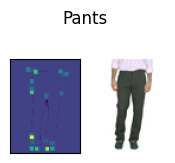

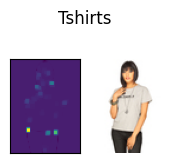

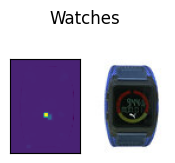

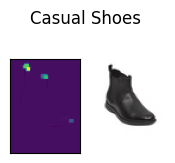

In [42]:
harris_images_sample = harris_corner_feature(sample_df['image'])
display_featimg_against_original_wrapper(harris_images_sample, sample_df)

In [43]:
harris_images_sample.shape

(4, 80, 60)

In [44]:
harris_images_train = harris_corner_feature(train_data['image'])
harris_images_train.shape

(3377, 80, 60)

In [45]:
# flatten image to use as feature
harris_images_train = harris_images_train.reshape((harris_images_train.shape[0],
                                                   harris_images_train.shape[1] * harris_images_train.shape[2]))
harris_images_train.shape

(3377, 4800)

In [46]:
harris_images_test = harris_corner_feature(test_data['image'])
harris_images_test = harris_images_test.reshape((harris_images_test.shape[0],
                                                 harris_images_test.shape[1] * harris_images_test.shape[2]))

harris_images_test.shape

(965, 4800)

In [47]:
harris_images_val = harris_corner_feature(validation_data['image'])
harris_images_val = harris_images_val.reshape((harris_images_val.shape[0],
                                               harris_images_val.shape[1] * harris_images_val.shape[2]))

harris_images_val.shape

(483, 4800)

#### SIFT Feature

Used for keypoints and corner detection

SIFT detects key points that are robust to changes in: Scale, Rotation, Affine transformations, Illumination, Projective transformation.

SIFT is scale and rotationally invariant, while Harris is only rotationally invariant.

SIFT has the following advantages:
1. Distinctiveness: Features can be compared with large datasets of objects
2. Quantity: SIFT can generate many features even from small objects
3. Efficiency: SIFT's performance is comparable to real-time performance
4. Locality: features are local, so robust to occlusion and clutter (no prior segmentation)

The SIFT detector is controlled by two parameters:
1. Peak threshold: Filters peaks of the DoG scale space that are too small
2. (Non) edge threshold: Controls the detector

In [48]:
def sift_feature(images):
  sift_imgs = []
  for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    image_sift = cv.drawKeypoints(gray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_imgs.append(image_sift)

  return np.array(sift_imgs)


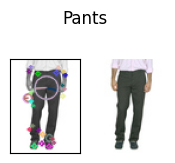

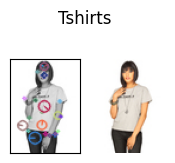

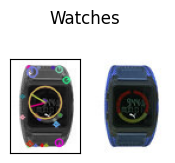

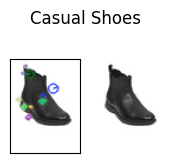

In [49]:
sift_images_sample = sift_feature(sample_df['image'])
display_featimg_against_original_wrapper(sift_images_sample, sample_df)

In [50]:
sift_images_sample.shape

(4, 80, 60, 3)

In [51]:
sift_images_train = sift_feature(train_data['image'])
sift_images_train.shape

(3377, 80, 60, 3)

In [52]:
# flatten image to use as feature
sift_images_train = sift_images_train.reshape((sift_images_train.shape[0],
                                               sift_images_train.shape[1] * sift_images_train.shape[2] * sift_images_train.shape[3]))
sift_images_train.shape

(3377, 14400)

In [53]:
sift_images_test = sift_feature(test_data['image'])
sift_images_test = sift_images_test.reshape((sift_images_test.shape[0],
                                             sift_images_test.shape[1] * sift_images_test.shape[2] * sift_images_test.shape[3]))

sift_images_test.shape

(965, 14400)

In [54]:
sift_images_val = sift_feature(validation_data['image'])
sift_images_val = sift_images_val.reshape((sift_images_val.shape[0],
                                           sift_images_val.shape[1] * sift_images_val.shape[2] * sift_images_val.shape[3]))

sift_images_val.shape

(483, 14400)

#### BRISK Feature

The Binary Robust Invariant Scalable Keypoints (BRISK) algorithm is a feature point detection and description algorithm. The BRISK algorithm constructs the feature descriptor of the local image through the gray scale relationship of random point pairs in the neighborhood of the local image.

The algorithm samples pixels over concentric rings. For each sampling point, a small patch is considered around it. Before starting the algorithm, the patch is smoothed using gaussian smoothing.

In [55]:
def brisk_feature(images):
  source = cv.BRISK_create()
  brisk_imgs = []
  for img in images:
      kp, des = source.detectAndCompute(img, None)
      imgKP = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
      brisk_imgs.append(imgKP)

  return np.array(brisk_imgs)

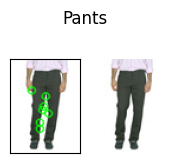

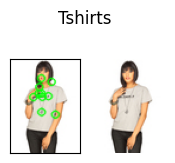

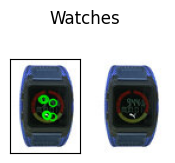

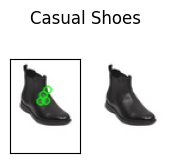

In [56]:
brisk_images_sample = brisk_feature(sample_df['image'])
display_featimg_against_original_wrapper(brisk_images_sample, sample_df)

#### Visual Bag of Words

https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f
https://github.com/AybukeYALCINER/gabor_sift_bovw/blob/master/assignment1.py


In [57]:
def vbow_sift_feature(images_by_class):
    sift_vectors = {}
    descriptor_list = []
    sift = cv.xfeatures2d.SIFT_create()
    for key, value in images_by_class.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img, None)
            if des is None:
              continue

            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features

    return [descriptor_list, sift_vectors]


def vbow_kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i])
           # count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            # dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind


def vbow_image_class(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature


def vbow_knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            minimum = 0
            key = "a" # predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        # minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        # dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            # print(minimum)

    return [num_test, correct_predict, class_based]


def vbow_knn_accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: " + str(avg_accuracy) + " %")
    print("Class based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : " + str(acc) + " %")

In [58]:
vbow_sift_train = vbow_sift_feature(train_data_dict)

# Takes the descriptor list which is unordered one
vbow_sift_train_descriptor_list = vbow_sift_train[0]

# Takes the sift features that is seperated class by class for train data
vbow_sift_train_all_feature = vbow_sift_train[1]

# Takes the sift features that is seperated class by class for test data
vbow_sift_test_all_feature = vbow_sift_feature(test_data_dict)[1]

# Takes the central points which is visual words
visual_words_train = vbow_kmeans(150, vbow_sift_train_descriptor_list)

# Creates histograms for train data
vbow_train = vbow_image_class(vbow_sift_train_all_feature, visual_words_train)

# Creates histograms for test data
vbow_test = vbow_image_class(vbow_sift_test_all_feature, visual_words_train)

In [59]:
len(vbow_train['Pants'])

793

In [60]:
len(vbow_test['Pants'])

234

In [61]:
results_vbow = vbow_knn(vbow_train, vbow_test)

vbow_knn_accuracy(results_vbow)

Average accuracy: 68.29015544041451 %
Class based accuracies: 

Pants : 88.03418803418803 %
Tshirts : 50.649350649350644 %
Watches : 51.00401606425703 %
Casual Shoes : 83.26693227091634 %


### Local Binary Pattern

LBP is a simple and efficient texture operator.

Here are some characteristics of LBP:
1. Low calculation cost
2. Invariant to image rotation and scale
3. Resists fluctuations in image gray scale values

LBP works by:
1. Thresholding the neighboring pixels of each pixel based on the value of the current pixel
2. Generating a binary code at each pixel
3. Labeling the pixels of an image as a binary number


In [62]:
def get_lbp_image(img):
    # only works on gray images
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # settings for LBP
    radius = 1
    n_points = 8 * radius
    METHOD = 'uniform'

    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    return lbp

def lbp_feature(images):
  lbp_imgs = []
  for img in images:
    lbp_imgs.append(get_lbp_image(img))

  return np.array(lbp_imgs)

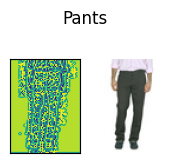

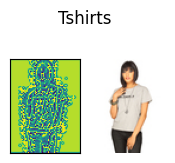

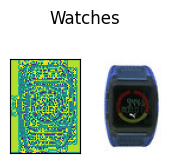

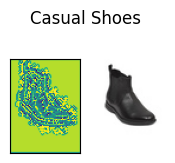

In [63]:
lbp_images_sample = lbp_feature(sample_df['image'])
display_featimg_against_original_wrapper(lbp_images_sample, sample_df)

In [64]:
lbp_images_sample.shape

(4, 80, 60)

### Histogram Based Features

#### RGB Histograms Feature

In [65]:
def rgb_hist_feature(img, plot=True, label=None):
  hist = None
  for i, col in enumerate(['b', 'g', 'r']):
    hist = cv.calcHist([img], [i], None, [256], [0, 256])

    if plot:
      # clip the edges so we don't get a long spike for the majority of cells that are white (255)
      hist_clipped = np.clip(hist, 0, 252)
      plt.plot(hist_clipped, color = col)
      plt.xlim([0, 252])
      plt.ylim([0, 200])

  if plot:
    plt.title(label)
    plt.show()

  return hist

def rgb_hist_feature_wrapper(data):
  rgb_hist = []
  for i in range(len(data)):
    hist = rgb_hist_feature(data.iloc[i]['image'], plot=False, label=data.iloc[i]['articleType'])
    rgb_hist.append(hist)

  return np.array(rgb_hist)

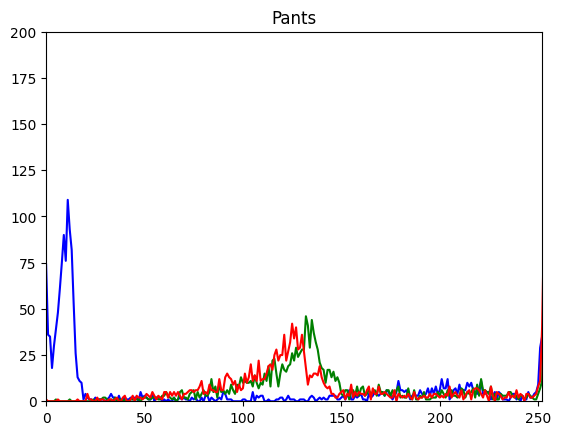

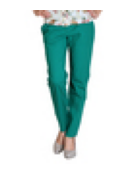

In [66]:
# plot individual pant - cherry pick a sample image and validate RBG intensity matches image
pant_idx = 1
rbg_hist_df_pants = rgb_hist_feature(df['image'][df["articleType"]=="Pants"].iloc[pant_idx],
                                     label="Pants")
print()
print_img(df['image'][df["articleType"]=="Pants"].iloc[pant_idx])

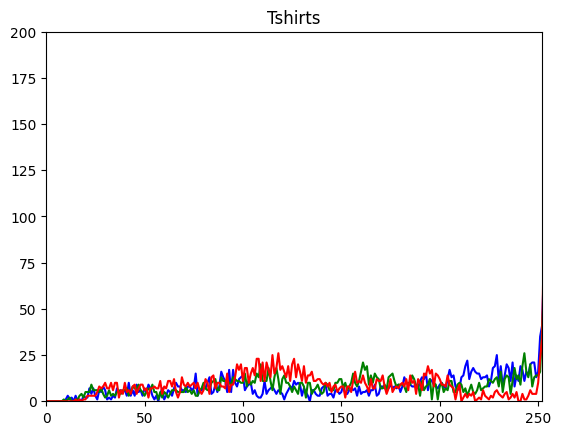

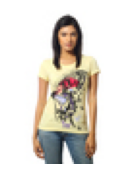

In [67]:
# plot individual tshirt - cherry pick a sample image and validate RBG intensity matches image
tshirt_idx = 15
rbg_hist_df_tshirts = rgb_hist_feature(df['image'][df["articleType"]=="Tshirts"].iloc[tshirt_idx],
                                       label="Tshirts")
print()
print_img(df['image'][df["articleType"]=="Tshirts"].iloc[tshirt_idx])

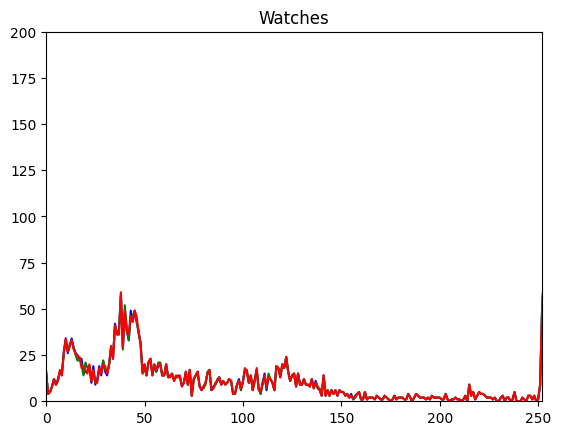

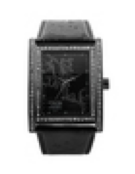

In [68]:
# plot individual watch - cherry pick a sample image and validate RBG intensity matches image
watches_idx = 5
rbg_hist_df_watches = rgb_hist_feature(df['image'][df["articleType"]=="Watches"].iloc[watches_idx],
                                       label="Watches")
print()
print_img(df['image'][df["articleType"]=="Watches"].iloc[watches_idx])

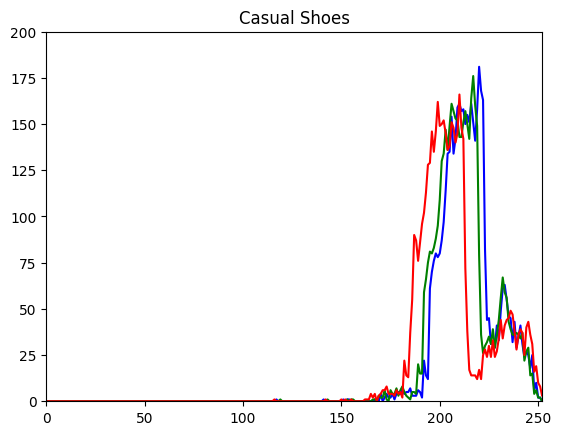

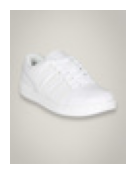

In [69]:
# plot individual shoe - cherry pick a sample image and validate RBG intensity matches image
shoes_idx = 5
rbg_hist_df_shoes = rgb_hist_feature(df['image'][df["articleType"]=="Casual Shoes"].iloc[shoes_idx],
                                     label="Casual Shoes")
print()
print_img(df['image'][df["articleType"]=="Casual Shoes"].iloc[shoes_idx])

In [70]:
rgb_hist_train = rgb_hist_feature_wrapper(train_data)
rgb_hist_train.shape

(3377, 256, 1)

In [71]:
# reshape by flattening the RGB histogram
rgb_hist_train = rgb_hist_train.reshape((rgb_hist_train.shape[0],
                                         rgb_hist_train.shape[1] * rgb_hist_train.shape[2]))
rgb_hist_train.shape

(3377, 256)

In [72]:
rgb_hist_test = rgb_hist_feature_wrapper(test_data)
rgb_hist_test = rgb_hist_test.reshape((rgb_hist_test.shape[0],
                                       rgb_hist_test.shape[1] * rgb_hist_test.shape[2]))
rgb_hist_test.shape

(965, 256)

In [73]:
rgb_hist_val = rgb_hist_feature_wrapper(validation_data)
rgb_hist_val = rgb_hist_val.reshape((rgb_hist_val.shape[0],
                                     rgb_hist_val.shape[1] * rgb_hist_val.shape[2]))
rgb_hist_val.shape

(483, 256)

#### HSV Histograms Feature

Its a better idea to use HSV histograms (for collecting channel information) compared to RGB histograms because the 3 channels in RGB are correlated to each other, whereas they are independent in the case of HSV


In [74]:
def hsv_hist_feature(rgb_img, label=None, plot=True, plot_value_only=True):

  hsv = to_hsv_img(rgb_img, return_img=True, display_img=False)

  # Split the HSV image into its channels.
  hue, saturation, value = cv.split(hsv)

  # Calculate the histograms for each channel.
  hue_hist = cv.calcHist([hue], [0], None, [180], [0, 180])
  saturation_hist = cv.calcHist([saturation], [0], None, [256], [0, 256])
  value_hist = cv.calcHist([value], [0], None, [256], [0, 256])

  # Normalize the histograms.
  # hue_hist /= np.sum(hue_hist)
  # saturation_hist /= np.sum(saturation_hist)
  # value_hist /= np.sum(value_hist)

  # Plot the histograms.
  if plot:
    low = 0
    high = 250
    h_clipped = np.clip(hue_hist, low, high)
    s_clipped = np.clip(saturation_hist, low, high)
    v_clipped = np.clip(value_hist, low, high)

    print(f"h_clipped has min {min(h_clipped)}, max {max(h_clipped)} and shape: {h_clipped.shape}")
    print(f"s_clipped has min {min(s_clipped)}, max {max(s_clipped)} and shape: {s_clipped.shape}")
    print(f"v_clipped has min {min(v_clipped)}, max {max(v_clipped)} and shape: {v_clipped.shape}")

    plt.plot(v_clipped, label="Value")

    if not plot_value_only:
      plt.plot(h_clipped, label="Hue")
      plt.plot(s_clipped, label="Saturation")

    plt.legend()
    plt.title(label)
    plt.show()

  return hue_hist, saturation_hist, value_hist

def hsv_hist_wrapper_feature(data, plot=True):
  h_list = []
  s_list = []
  v_list = []
  for i in range(len(data)):
    h, s, v = hsv_hist_feature(data.iloc[i]['image'], data.iloc[i]['articleType'], plot)
    h_list.append(h)
    s_list.append(s)
    v_list.append(v)
    print()

  n = len(h_list)
  dim_h = h_list[0].shape[0]
  dim_s = s_list[0].shape[0]
  dim_v = v_list[0].shape[0]

  h_list = np.array(h_list).reshape((n, dim_h))
  s_list = np.array(s_list).reshape((n, dim_s))
  v_list = np.array(v_list).reshape((n, dim_v))
  return h_list, s_list, v_list

h_clipped has min [0.], max [250.] and shape: (180, 1)
s_clipped has min [0.], max [250.] and shape: (256, 1)
v_clipped has min [0.], max [250.] and shape: (256, 1)


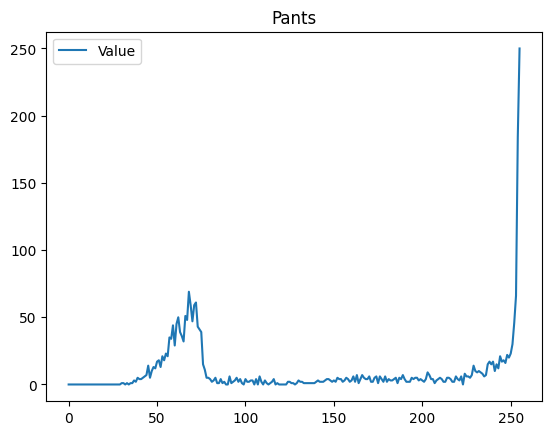


h_clipped has min [0.], max [250.] and shape: (180, 1)
s_clipped has min [0.], max [250.] and shape: (256, 1)
v_clipped has min [0.], max [250.] and shape: (256, 1)


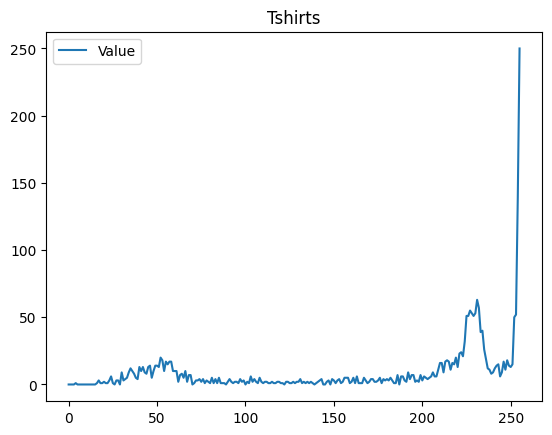


h_clipped has min [0.], max [250.] and shape: (180, 1)
s_clipped has min [0.], max [250.] and shape: (256, 1)
v_clipped has min [0.], max [250.] and shape: (256, 1)


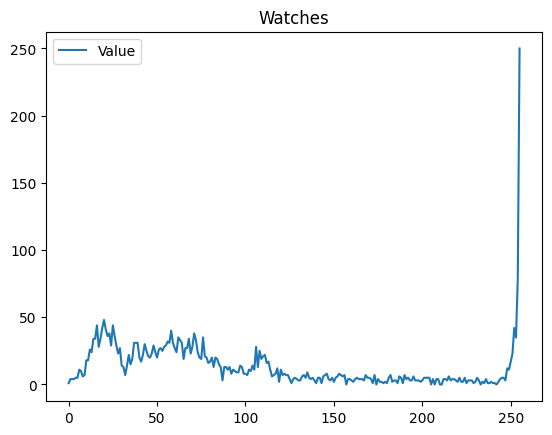


h_clipped has min [0.], max [250.] and shape: (180, 1)
s_clipped has min [0.], max [250.] and shape: (256, 1)
v_clipped has min [0.], max [250.] and shape: (256, 1)


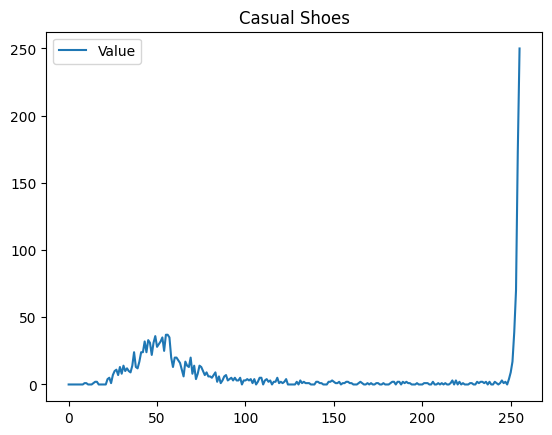

In [75]:
# will likely have to clip the 0 and 255 values in order to get a proper graph
h, s, v = hsv_hist_wrapper_feature(sample_df)

In [76]:
print(h.shape)
print(s.shape)
print(v.shape)

(4, 180)
(4, 256)
(4, 256)


In [77]:
h_train, s_train, v_train = hsv_hist_wrapper_feature(train_data, plot=False)
print(h_train.shape)
print(s_train.shape)
print(v_train.shape)

In [78]:
h_test, s_test, v_test = hsv_hist_wrapper_feature(test_data, plot=False)
print(h_test.shape)
print(s_test.shape)
print(v_test.shape)






































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































(965, 180)
(965, 256)
(965, 256)


In [79]:
h_val, s_val, v_val = hsv_hist_wrapper_feature(validation_data, plot=False)
print(h_val.shape)
print(s_val.shape)
print(v_val.shape)




































































































































































































































































































































































































































































































(483, 180)
(483, 256)
(483, 256)


### PCA by Feature


In [80]:
def pca_analysis(feature_name, feature_arr, pca_n_components=150, plot=True):
  print(f"Feature array shape is {feature_arr.shape}")
  pca = PCA(n_components = pca_n_components)
  pca.fit(feature_arr)
  transformed_pca = pca.transform(feature_arr)
  print(f"PCA Transformed feature array shape is {transformed_pca.shape}")
  pca_sum_exp_var = sum(pca.explained_variance_ratio_)
  print(f"The sum of the explained variance ratio for feature: {feature_name} is {pca_sum_exp_var}")

  if plot:
    fig = plt.figure(figsize = (15, 7))
    fig.add_subplot(131)
    plt.title(feature_name)
    plt.ylabel('Variation explained')
    plt.xlabel('Number of PCA Components')
    plt.bar(list(range(1, pca_n_components + 1)), pca.explained_variance_ratio_)

  return transformed_pca, pca.explained_variance_ratio_

#### PCA for Train Data

Feature array shape is (3377, 1728)
PCA Transformed feature array shape is (3377, 300)
The sum of the explained variance ratio for feature: HOG feature is 0.9449602000501168


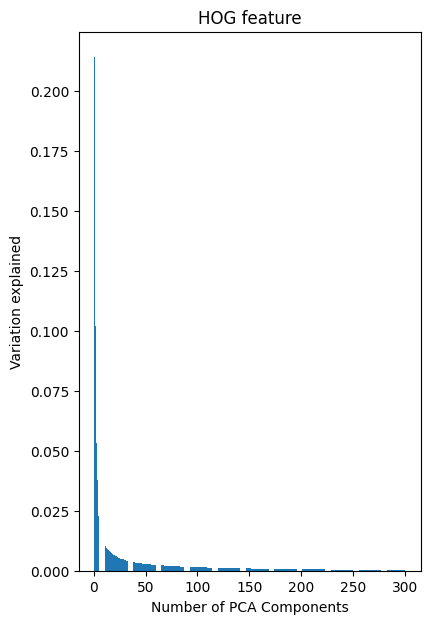

In [81]:
# pca for HOG
transformed_pca_hog_train, exp_var_hog_train = pca_analysis("HOG feature", hog_features_train, pca_n_components=300)

Feature array shape is (50, 1000)
PCA Transformed feature array shape is (50, 10)
The sum of the explained variance ratio for feature: VGG feature is 0.8627850636839867


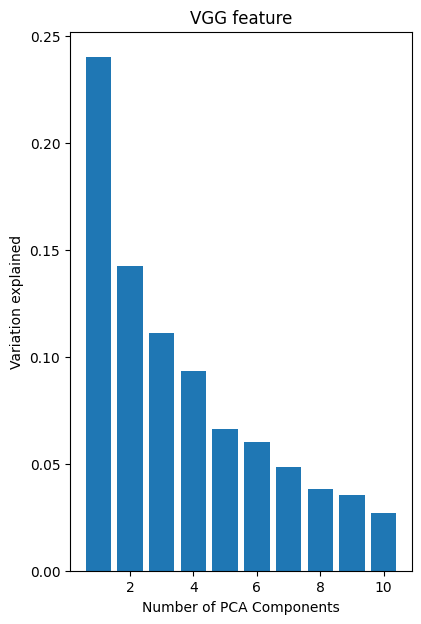

In [82]:
# pca for VGG
transformed_pca_vgg_train, exp_var_vgg_train = pca_analysis("VGG feature", vgg_features_train, pca_n_components=10)

Feature array shape is (3377, 1000)
PCA Transformed feature array shape is (3377, 150)
The sum of the explained variance ratio for feature: ResNet 101 feature is 0.9995590825610634


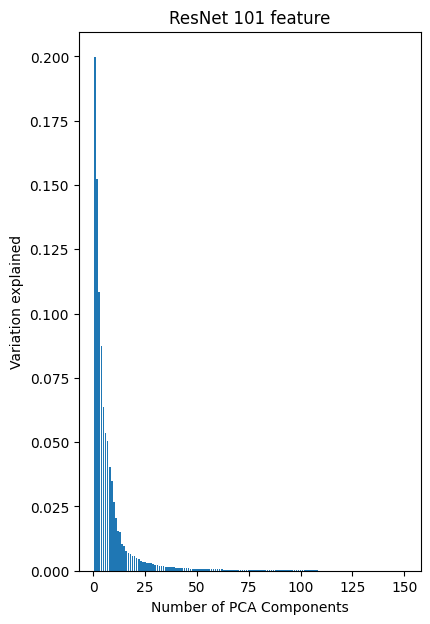

In [83]:
# pca for ResNet101
transformed_pca_resnet_train, exp_var_resnet_train = pca_analysis("ResNet 101 feature",
                                                                  resnet101_features_train)

Feature array shape is (3377, 4800)
PCA Transformed feature array shape is (3377, 400)
The sum of the explained variance ratio for feature: Harris Corner feature is 0.9059483567543793


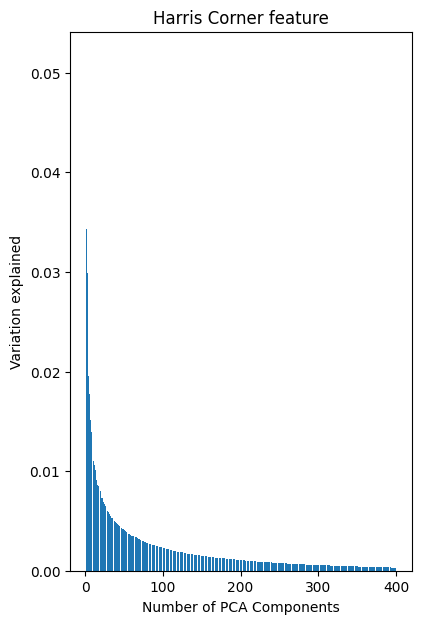

In [84]:
# pca for harris corner points feature
transformed_pca_harris_train, exp_var_harris_train = pca_analysis("Harris Corner feature",
                                                                  harris_images_train,
                                                                  pca_n_components=400)

Feature array shape is (3377, 14400)
PCA Transformed feature array shape is (3377, 400)
The sum of the explained variance ratio for feature: SIFT feature is 0.8939649743577655


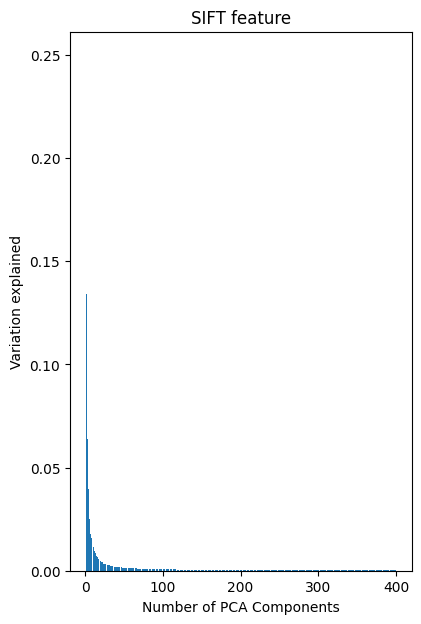

In [85]:
# pca for sift feature
transformed_pca_sift_train, exp_var_sift_train = pca_analysis("SIFT feature", sift_images_train, pca_n_components=400)

Feature array shape is (3377, 256)
PCA Transformed feature array shape is (3377, 10)
The sum of the explained variance ratio for feature: RGB Hist feature is 0.9821477713994682


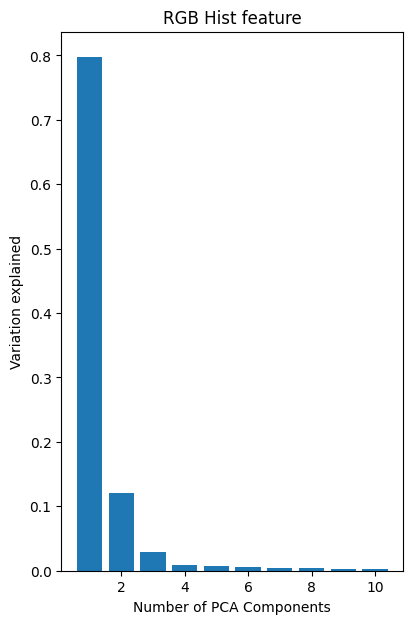

In [86]:
# pca for rgb hist feature
transformed_pca_rgb_hist_train, exp_var_rgb_hist_train = pca_analysis("RGB Hist feature",
                                                                      rgb_hist_train,
                                                                      pca_n_components=10)

Feature array shape is (3377, 256)
PCA Transformed feature array shape is (3377, 10)
The sum of the explained variance ratio for feature: HSV Hist (Value) feature is 0.9821917486842722


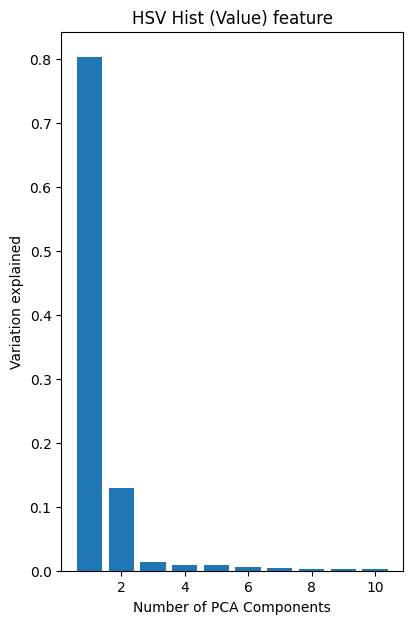

In [87]:
# pca for hsv hist feature (value part of HSV)
# Hue and saturation don't give anything useful
transformed_pca_hsv_v_hist_train, exp_var_hsv_v_hist_train = pca_analysis("HSV Hist (Value) feature",
                                                                          v_train,
                                                                          pca_n_components=10)

#### PCA for Validation Data

In [88]:
transformed_pca_hog_val, exp_var_hog_val = pca_analysis("HOG feature", hog_features_val,
                                                          pca_n_components=300, plot=False)

transformed_pca_harris_val, exp_var_harris_val = pca_analysis("Harris Corner feature",
                                                                harris_images_val,
                                                                pca_n_components=400,
                                                                plot=False)

transformed_pca_sift_val, exp_var_sift_val = pca_analysis("SIFT feature",
                                                            sift_images_val,
                                                            pca_n_components=400,
                                                            plot=False)

transformed_pca_rgb_hist_val, exp_var_rgb_hist_val = pca_analysis("RGB Hist feature",
                                                                    rgb_hist_val,
                                                                    pca_n_components=10,
                                                                    plot=False)

transformed_pca_hsv_v_hist_val, exp_var_hsv_v_hist_val = pca_analysis("HSV Hist (Value) feature",
                                                                        v_val,
                                                                        pca_n_components=10,
                                                                        plot=False)

# transformed_pca_vgg_test, exp_var_vgg_test = pca_analysis("VGG feature", vgg_features_test, pca_n_components=10, plot=False)
transformed_pca_resnet_val, exp_var_resnet_val = pca_analysis("ResNet 101 feature",
                                                                resnet101_features_val,
                                                                plot=False)

Feature array shape is (483, 1728)
PCA Transformed feature array shape is (483, 300)
The sum of the explained variance ratio for feature: HOG feature is 0.9855293084371166
Feature array shape is (483, 4800)
PCA Transformed feature array shape is (483, 400)
The sum of the explained variance ratio for feature: Harris Corner feature is 0.9982609272738046
Feature array shape is (483, 14400)
PCA Transformed feature array shape is (483, 400)
The sum of the explained variance ratio for feature: SIFT feature is 0.9885274325114504
Feature array shape is (483, 256)
PCA Transformed feature array shape is (483, 10)
The sum of the explained variance ratio for feature: RGB Hist feature is 0.9867350792046636
Feature array shape is (483, 256)
PCA Transformed feature array shape is (483, 10)
The sum of the explained variance ratio for feature: HSV Hist (Value) feature is 0.9884345525642857
Feature array shape is (483, 1000)
PCA Transformed feature array shape is (483, 150)
The sum of the explained vari

#### PCA for Test Data

In [89]:
transformed_pca_hog_test, exp_var_hog_test = pca_analysis("HOG feature", hog_features_test,
                                                          pca_n_components=300, plot=False)

transformed_pca_harris_test, exp_var_harris_test = pca_analysis("Harris Corner feature",
                                                                harris_images_test,
                                                                pca_n_components=400,
                                                                plot=False)

transformed_pca_sift_test, exp_var_sift_test = pca_analysis("SIFT feature",
                                                            sift_images_test,
                                                            pca_n_components=400,
                                                            plot=False)

transformed_pca_rgb_hist_test, exp_var_rgb_hist_test = pca_analysis("RGB Hist feature",
                                                                    rgb_hist_test,
                                                                    pca_n_components=10,
                                                                    plot=False)

transformed_pca_hsv_v_hist_test, exp_var_hsv_v_hist_test = pca_analysis("HSV Hist (Value) feature",
                                                                        v_test,
                                                                        pca_n_components=10,
                                                                        plot=False)

# transformed_pca_vgg_test, exp_var_vgg_test = pca_analysis("VGG feature", vgg_features_test, pca_n_components=10, plot=False)
transformed_pca_resnet_test, exp_var_resnet_test = pca_analysis("ResNet 101 feature",
                                                                resnet101_features_test,
                                                                plot=False)

Feature array shape is (965, 1728)
PCA Transformed feature array shape is (965, 300)
The sum of the explained variance ratio for feature: HOG feature is 0.9639905599297507
Feature array shape is (965, 4800)
PCA Transformed feature array shape is (965, 400)
The sum of the explained variance ratio for feature: Harris Corner feature is 0.9703068242815789
Feature array shape is (965, 14400)
PCA Transformed feature array shape is (965, 400)
The sum of the explained variance ratio for feature: SIFT feature is 0.9408054805455328
Feature array shape is (965, 256)
PCA Transformed feature array shape is (965, 10)
The sum of the explained variance ratio for feature: RGB Hist feature is 0.9867881473619491
Feature array shape is (965, 256)
PCA Transformed feature array shape is (965, 10)
The sum of the explained variance ratio for feature: HSV Hist (Value) feature is 0.9875543396919966
Feature array shape is (965, 1000)
PCA Transformed feature array shape is (965, 150)
The sum of the explained vari

## Classifiers

### Logistic Regression and SVM

In [91]:
X_train = transformed_pca_hog_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_hog_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

model_logit = LogisticRegression(max_iter=2000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],              # Penalty type
    'solver': ['liblinear', 'saga']      # Solver type
}

grid_search = GridSearchCV(model_logit, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_logreg = LogisticRegression(**best_params)

start_train_time = time.time()
best_logreg.fit(X_train, Y_train)
end_train_time = time.time()

X_val = transformed_pca_hog_val
Y_val = validation_data['articleType']
start_pred_time = time.time()
y_val_pred = best_logreg.predict(X_val)
end_pred_time = time.time()

print("Validation Accuracy for Each Parameter Set:")
for params, accuracy in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"{params}: {accuracy:.4f}")

accuracy = accuracy_score(Y_val, y_val_pred)
start_test_time = time.time()
y_test_pred = best_logreg.predict(X_test)
end_test_time = time.time()
print(f"Best Hyperparameters: {best_params}")
print(f"Validation Accuracy: {accuracy}")
print(f"Testing Accuracy: {accuracy_score(Y_test, y_test_pred)}")
print(f"Training Time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction Time for Validation: {end_pred_time - start_pred_time:.4f} seconds")
print(f"Prediction Time for Test: {end_test_time - start_test_time:.4f} seconds")
print(classification_report(Y_test, y_test_pred))

X train is (3377, 300)
Y train is (3377,)
X test is (965, 300)
Y test is (965,)
Validation Accuracy for Each Parameter Set:
{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}: 0.9203
{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}: 0.9393
{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}: 0.9855
{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}: 0.9902
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}: 0.9766
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}: 0.9790
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}: 0.9932
{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}: 0.9932
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}: 0.9914
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}: 0.9911
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}: 0.9956
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}: 0.9950
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}: 0.9950
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}: 0.9938
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}: 0.9962
{'C': 1, 'penalty': 

In [92]:
model_svm = SVC(max_iter=2000,kernel="rbf")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],        # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],       # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Kernel coefficient (only for 'rbf' and 'poly' kernels)
}
grid_search = GridSearchCV(model_svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_svc = SVC(**best_params)
start_train_time = time.time()
best_svc.fit(X_train, Y_train)
end_train_time = time.time()
start_pred_time = time.time()
y_val_pred = best_svc.predict(X_val)
end_pred_time = time.time()
print("Validation Accuracy for Each Parameter Set:")
for params, accuracy in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"{params}: {accuracy:.4f}")
accuracy = accuracy_score(Y_val, y_val_pred)
start_test_time = time.time()
y_test_pred = best_svc.predict(X_test)
end_test_time = time.time()
print(f"Best Hyperparameters: {best_params}")
print(f"Validation Accuracy: {accuracy}")
print(f"Testing Accuracy: {accuracy_score(Y_test, y_test_pred)}")
print(f"Training Time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction Time for Validation: {end_pred_time - start_pred_time:.4f} seconds")
print(f"Prediction Time for Test: {end_test_time - start_test_time:.4f} seconds")
print(classification_report(Y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Validation Accuracy for Each Parameter Set:
{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 'auto', 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.001, 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}: 0.9630
{'C': 0.001, 'gamma': 1, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 1

In [93]:
X_train = transformed_pca_harris_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_harris_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = transformed_pca_harris_val
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using Harris is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using Harris is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using Harris is {model_svm.score(X_val, Y_val)}")
print(f"The test set accuracy for SVM using Harris is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 400)
Y train is (3377,)
X test is (965, 400)
Y test is (965,)
The validation set accuracy for logit using Harris is 0.41821946169772256
The test set accuracy for logit using Harris is 0.38756476683937824
              precision    recall  f1-score   support

Casual Shoes       0.47      0.66      0.55       251
       Pants       0.37      0.39      0.38       234
     Tshirts       0.35      0.28      0.31       231
     Watches       0.29      0.21      0.24       249

    accuracy                           0.39       965
   macro avg       0.37      0.39      0.37       965
weighted avg       0.37      0.39      0.37       965

The validation set accuracy for SVM using Harris is 0.46790890269151136
The test set accuracy for SVM using Harris is 0.46217616580310883
              precision    recall  f1-score   support

Casual Shoes       0.68      0.76      0.72       251
       Pants       0.37      0.41      0.39       234
     Tshirts       0.43      0.28      0.3

In [94]:
X_train = transformed_pca_sift_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_sift_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = transformed_pca_sift_val
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using SIFT is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using SIFT is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using SIFT is {model_svm.score(X_val, Y_val)}")
print(f"The test set accuracy for SVM using SIFT is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 400)
Y train is (3377,)
X test is (965, 400)
Y test is (965,)
The validation set accuracy for logit using SIFT is 0.19875776397515527
The test set accuracy for logit using SIFT is 0.8507772020725388
              precision    recall  f1-score   support

Casual Shoes       0.93      1.00      0.96       251
       Pants       0.92      0.88      0.90       234
     Tshirts       0.74      0.76      0.75       231
     Watches       0.80      0.77      0.78       249

    accuracy                           0.85       965
   macro avg       0.85      0.85      0.85       965
weighted avg       0.85      0.85      0.85       965

The validation set accuracy for SVM using SIFT is 0.2608695652173913
The test set accuracy for SVM using SIFT is 0.9357512953367876
              precision    recall  f1-score   support

Casual Shoes       0.98      0.99      0.98       251
       Pants       0.96      0.97      0.96       234
     Tshirts       0.92      0.86      0.89       231

In [95]:
X_train = transformed_pca_rgb_hist_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_rgb_hist_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = transformed_pca_rgb_hist_val
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using RBG Histogram is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using RBG Histogram is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using RGB Histogram is {model_svm.score(X_val, Y_val)}")
print(f"The test set accuracy for SVM using RGB Histogram is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 10)
Y train is (3377,)
X test is (965, 10)
Y test is (965,)
The validation set accuracy for logit using RBG Histogram is 0.41821946169772256
The test set accuracy for logit using RBG Histogram is 0.505699481865285
              precision    recall  f1-score   support

Casual Shoes       0.63      0.79      0.70       251
       Pants       0.49      0.41      0.44       234
     Tshirts       0.42      0.45      0.44       231
     Watches       0.43      0.36      0.39       249

    accuracy                           0.51       965
   macro avg       0.49      0.50      0.49       965
weighted avg       0.50      0.51      0.50       965

The validation set accuracy for SVM using RGB Histogram is 0.5817805383022774
The test set accuracy for SVM using RGB Histogram is 0.6310880829015544
              precision    recall  f1-score   support

Casual Shoes       0.70      0.89      0.79       251
       Pants       0.53      0.33      0.41       234
     Tshirts       0

In [96]:
X_train = transformed_pca_hsv_v_hist_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_hsv_v_hist_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = transformed_pca_hsv_v_hist_val
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using HSV V is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using HSV V is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using HSV V is {model_svm.score(X_val, Y_val)}")
print(f"The accuracy for SVM using HSV V is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 10)
Y train is (3377,)
X test is (965, 10)
Y test is (965,)
The validation set accuracy for logit using HSV V is 0.40165631469979296
The test set accuracy for logit using HSV V is 0.45595854922279794
              precision    recall  f1-score   support

Casual Shoes       0.52      0.81      0.63       251
       Pants       0.34      0.22      0.27       234
     Tshirts       0.39      0.16      0.23       231
     Watches       0.45      0.59      0.51       249

    accuracy                           0.46       965
   macro avg       0.43      0.45      0.41       965
weighted avg       0.43      0.46      0.42       965

The validation set accuracy for SVM using HSV V is 0.494824016563147
The accuracy for SVM using HSV V is 0.6404145077720207
              precision    recall  f1-score   support

Casual Shoes       0.73      0.88      0.80       251
       Pants       0.51      0.59      0.54       234
     Tshirts       0.58      0.52      0.55       231
     W

In [97]:
X_train = transformed_pca_resnet_train

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = transformed_pca_resnet_test

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = transformed_pca_resnet_val
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using ResNet 101 is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using ResNet 101 is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using ResNet 101 is {model_svm.score(X_val, Y_val)}")
print(f"The test set accuracy for SVM using ResNet 101 is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 150)
Y train is (3377,)
X test is (965, 150)
Y test is (965,)
The validation set accuracy for logit using ResNet 101 is 0.8012422360248447
The test set accuracy for logit using ResNet 101 is 0.46424870466321244
              precision    recall  f1-score   support

Casual Shoes       0.83      0.73      0.78       251
       Pants       0.75      0.98      0.85       234
     Tshirts       0.12      0.14      0.13       231
     Watches       0.01      0.01      0.01       249

    accuracy                           0.46       965
   macro avg       0.43      0.47      0.44       965
weighted avg       0.43      0.46      0.44       965

The validation set accuracy for SVM using ResNet 101 is 0.7432712215320911
The test set accuracy for SVM using ResNet 101 is 0.5015544041450777
              precision    recall  f1-score   support

Casual Shoes       0.84      0.65      0.74       251
       Pants       0.81      0.91      0.85       234
     Tshirts       0.15      

In [98]:
X_train = np.hstack((transformed_pca_hog_train, transformed_pca_resnet_train))

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = np.hstack((transformed_pca_hog_test, transformed_pca_resnet_test))

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = np.hstack((transformed_pca_hog_val, transformed_pca_resnet_val))
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using HOG and ResNet 101 is {model_logit.score(X_val, Y_val)}")
print(f"The test set accuracy for logit using HOG and ResNet 101 is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

X train is (3377, 450)
Y train is (3377,)
X test is (965, 450)
Y test is (965,)
The validation set accuracy for logit using HOG and ResNet 101 is 0.9648033126293996
The test set accuracy for logit using HOG and ResNet 101 is 0.9751295336787564
              precision    recall  f1-score   support

Casual Shoes       0.99      0.99      0.99       251
       Pants       0.97      0.98      0.98       234
     Tshirts       0.99      0.97      0.98       231
     Watches       0.95      0.96      0.96       249

    accuracy                           0.98       965
   macro avg       0.98      0.97      0.98       965
weighted avg       0.98      0.98      0.98       965



In [99]:
model_svm = SVC(max_iter=2000,kernel="rbf")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],        # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],       # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Kernel coefficient (only for 'rbf' and 'poly' kernels)
}
grid_search = GridSearchCV(model_svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_svc = SVC(**best_params)
start_train_time = time.time()
best_svc.fit(X_train, Y_train)
end_train_time = time.time()
start_pred_time = time.time()
y_val_pred = best_svc.predict(X_val)
end_pred_time = time.time()
print("Validation Accuracy for Each Parameter Set:")
for params, accuracy in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"{params}: {accuracy:.4f}")
accuracy = accuracy_score(Y_val, y_val_pred)
start_test_time = time.time()
y_test_pred = best_svc.predict(X_test)
end_test_time = time.time()
print(f"Best Hyperparameters: {best_params}")
print(f"Validation Accuracy: {accuracy}")
print(f"Testing Accuracy: {accuracy_score(Y_test, y_test_pred)}")
print(f"Training Time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction Time for Validation: {end_pred_time - start_pred_time:.4f} seconds")
print(f"Prediction Time for Test: {end_test_time - start_test_time:.4f} seconds")
print(classification_report(Y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

Validation Accuracy for Each Parameter Set:
{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 'auto', 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.001, 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}: 0.2787
{'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}: 0.9659
{'C': 0.001, 'gamma': 1, 'kernel': 'linear'}: 0.9941
{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}: 0.2787
{'C': 0.001, 'gamma': 1

In [100]:
X_train = np.hstack((transformed_pca_hog_train, transformed_pca_harris_train, transformed_pca_resnet_train))

X_train = pd.DataFrame(X_train)
print(f"X train is {X_train.shape}")

Y_train = train_data['articleType']
print(f"Y train is {Y_train.shape}")

X_test = np.hstack((transformed_pca_hog_test, transformed_pca_harris_test, transformed_pca_resnet_test))

X_test = pd.DataFrame(X_test)
print(f"X test is {X_test.shape}")

Y_test = test_data['articleType']
print(f"Y test is {Y_test.shape}")

X_val = np.hstack((transformed_pca_hog_val, transformed_pca_harris_val, transformed_pca_resnet_val))
Y_val = validation_data['articleType']

model_logit = LogisticRegression(max_iter=2000)
model_logit.fit(X_train, Y_train)
print(f"The validation set accuracy for logit using HOG, Harris, and ResNet 101 is {model_logit.score(X_test, Y_test)}")
print(f"The test set accuracy for logit using HOG, Harris, and ResNet 101 is {model_logit.score(X_test, Y_test)}")

test_preds_logit = model_logit.predict(X_test)
print(classification_report(Y_test, test_preds_logit))

model_svm = SVC(max_iter=2000,kernel="rbf")
model_svm.fit(X_train, Y_train)
print(f"The validation set accuracy for SVM using HOG, Harris, and ResNet 101 is {model_svm.score(X_test, Y_test)}")
print(f"The accuracy for SVM using HOG, Harris, and ResNet 101 is {model_svm.score(X_test, Y_test)}")
test_preds_svm = model_svm.predict(X_test)
print(classification_report(Y_test, test_preds_svm))

X train is (3377, 850)
Y train is (3377,)
X test is (965, 850)
Y test is (965,)
The validation set accuracy for logit using HOG, Harris, and ResNet 101 is 0.38756476683937824
The test set accuracy for logit using HOG, Harris, and ResNet 101 is 0.38756476683937824
              precision    recall  f1-score   support

Casual Shoes       0.47      0.66      0.55       251
       Pants       0.37      0.39      0.38       234
     Tshirts       0.35      0.28      0.31       231
     Watches       0.29      0.21      0.24       249

    accuracy                           0.39       965
   macro avg       0.37      0.39      0.37       965
weighted avg       0.37      0.39      0.37       965

The validation set accuracy for SVM using HOG, Harris, and ResNet 101 is 0.46217616580310883
The accuracy for SVM using HOG, Harris, and ResNet 101 is 0.46217616580310883
              precision    recall  f1-score   support

Casual Shoes       0.68      0.76      0.72       251
       Pants       0.